In [1]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils.data as torch_data
import sklearn
from sklearn.metrics import accuracy_score

In [2]:
import random

import torch
from   torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from   torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import random_split
import numpy as np

In [3]:
train_dir = "./catsdogs/PetImages"
train_dogs_dir = f'{train_dir}/Dog'
train_cats_dir = f'{train_dir}/Cat'
val_dir = "./Val"
val_dogs_dir = f'{val_dir}/Dog'
val_cats_dir = f'{val_dir}/Cat'

In [4]:
import os
import re
import shutil
files = os.listdir(train_cats_dir)
for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)
print("Printing val cat dir")
!ls {val_cats_dir} | head -n 5

Printing val cat dir
5000.jpg
5001.jpg
5002.jpg
5003.jpg
5004.jpg


In [5]:
files = os.listdir(train_dogs_dir)
for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
print("Printing val dog dir")
!ls {val_dogs_dir} | head -n 5

Printing val dog dir
5000.jpg
5001.jpg
5002.jpg
5003.jpg
5004.jpg


In [6]:
train_transforms = transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(64),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(65),
                                      transforms.CenterCrop(64),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [7]:
#catsdogs_train = datasets.ImageFolder('./drive/My Drive/Data/PetImages',  
                                    #transform=train_transforms)                                       
catsdogs_val = datasets.ImageFolder('./Val', 
                                    transform=test_transforms)

In [10]:
#train_loader = torch_data.DataLoader(catsdogs_train, batch_size=100, shuffle=True) 
val_loader = torch_data.DataLoader(catsdogs_val, batch_size=100, shuffle=False) 

In [11]:
def get_accuracy(net, val_dset):
    test_loader = torch_data.DataLoader(val_dset,batch_size = len(val_dset)) 
    net.eval()
    for X,y in test_loader:
        X = X.to(device)
        y = y.to(device)
        nn_outputs = net(X).detach().cpu().argmax(axis = 1)
    return accuracy_score(nn_outputs,y.detach().cpu())

# POSLAYERS

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils.data as torch_data
import sklearn
from sklearn.metrics import accuracy_score

class Dense(nn.Linear):
    def __init__(self, *args,**kwargs):
        super(Dense, self).__init__(*args,**kwargs)
    
    def get_sparsity(self):
        data = self.weight.data
        return (data == 0).sum().item() / (data.shape[0] * data.shape[1])
    
    def l1reg(self, device='cpu'):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, W in self.named_parameters():
            l1_reg = l1_reg + W.norm(1)
        return l1_reg

class PosDense(nn.Linear):
    def __init__(self, *args,**kwargs):
        super(PosDense, self).__init__(*args,**kwargs)
    
    def positivate(self):
        self.weight.data = F.relu(self.weight.data)
    
    def get_sparsity(self):
        data = self.weight.data
        return (data == 0).sum().item() / (data.shape[0] * data.shape[1])
    
    def l1reg(self, device):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, W in self.named_parameters():
            l1_reg = l1_reg + W.norm(1)
        return l1_reg

class PosConv2d(nn.Conv2d):
    def __init__(self, *args,**kwargs):
        super(PosConv2d, self).__init__(*args,**kwargs)
    
    def positivate(self):
        self.weight.data = F.relu(self.weight.data)

# Usual Alexnet without regularization

In [85]:
from tqdm.notebook import tqdm

In [97]:
class ICAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ICAlexNet, self).__init__()
        self.conv = PosConv2d(32, 64, kernel_size=3)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32), 
            self.conv,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        
        self.fc1 = PosDense(12544, 512)
        self.fc2 = Dense(512, num_classes)

        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            self.fc1,
            nn.ReLU(inplace=True),
            self.fc2,
        )

    def forward(self, x):
        conv_features = self.features(x)
        flatten = conv_features.view(conv_features.size(0), -1)
        fc = self.fc_layers(flatten)
        return fc
    
    def l1reg(self, device):
        return self.fc1.l1reg(device) + self.fc2.l1reg(device)
    
    def get_sparsities(self):
        return {
                'fc1': self.fc1.get_sparsity(),
                'fc2': self.fc2.get_sparsity()
        }
    
    def positivate(self):
      self.conv.positivate()
      self.fc1.positivate()

In [98]:
net = ICConvNet()

In [99]:
net

ICConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PosConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): PosDense(in_features=12544, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dense(in_features=512, out_features=2, bias=True)
  )
)

In [102]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        
        self.fc1 = Dense(12544, 512)
        self.fc2 = Dense(512, num_classes)

        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            self.fc1,
            nn.ReLU(inplace=True),
            self.fc2,
        )

    def forward(self, x):
        conv_features = self.features(x)
        flatten = conv_features.view(conv_features.size(0), -1)
        fc = self.fc_layers(flatten)
        return fc
    
    def l1reg(self, device):
        return self.fc1.l1reg(device) + self.fc2.l1reg(device)
    
    def get_sparsities(self):
        return {
                'fc1': self.fc1.get_sparsity(),
                'fc2': self.fc2.get_sparsity()
        }

In [95]:
net = ConvNet()

In [96]:
net

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dense(in_features=12544, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dense(in_features=512, out_features=2, bias=True)
  )
)

# AlexNet

In [52]:
device='cpu'

In [53]:
net = AlexNet()

In [54]:
net.load_state_dict(torch.load('alexnet/alexnet47+', map_location=torch.device('cpu')))

<All keys matched successfully>

In [47]:
get_accuracy(net, catsdogs_val)

0.8905

In [55]:
net.get_sparsities()

{'fc1': 0.0, 'fc2': 0.0}

In [48]:
alexnet_val_losses = np.load('alexnet/val_loss_alexnet.npy')
alexnet_val_losses = np.hstack((alexnet_val_losses, np.load('alexnet/val_loss_alexnet20+.npy')))
alexnet_val_losses = np.hstack((alexnet_val_losses, np.load('alexnet/val_loss_alexnet40+.npy')))
alexnet_val_losses = np.hstack((alexnet_val_losses, np.load('alexnet/val_loss_alexnet47+.npy')))[:50]

In [64]:
alexnet_val_accs = np.load('alexnet/val_acc_alexnet.npy')
alexnet_val_accs = np.hstack((alexnet_val_accs, np.load('alexnet/val_acc_alexnet20+.npy')))
alexnet_val_accs = np.hstack((alexnet_val_accs, np.load('alexnet/val_acc_alexnet40+.npy')))
alexnet_val_accs = np.hstack((alexnet_val_accs, np.load('alexnet/val_acc_alexnet47+.npy')))[:50]

# PosAlexNet

In [56]:
net = ICAlexNet(num_classes=2)

In [57]:
net.load_state_dict(torch.load('alexnet/posalexnet', map_location=torch.device('cpu')))

<All keys matched successfully>

In [58]:
device='cpu'
get_accuracy(net, catsdogs_val)

0.7885

In [59]:
(net.get_sparsities()['fc1'] * 12544 * 512) / (12544 * 512 + 512 * 2)

0.06577778151402837

In [75]:
posalex_loss = np.load('alexnet/val_loss_posalexnet.npy')
posalex_acc = np.load('alexnet/val_acc_posalexnet.npy')

# PosAlex + L1

In [67]:
net = ICAlexNet(num_classes=2)

In [69]:
net.load_state_dict(torch.load('alexnet/posalexnet_l1', map_location=torch.device('cpu')))

<All keys matched successfully>

In [70]:
get_accuracy(net, catsdogs_val)

0.7865

In [71]:
net.get_sparsities()

{'fc1': 0.9819915148676658, 'fc2': 0.0}

In [72]:
(net.get_sparsities()['fc1'] * 12544 * 512) / (12544 * 512 + 512 * 2)

0.981834972301929

In [74]:
posalexl1_loss = np.load('alexnet/val_loss_posalexnet_l1.npy')
posalexl1_acc = np.load('alexnet/val_acc_posalexnet_l1.npy')

# AlexNet + L1

In [107]:
class PosAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(PosAlexNet, self).__init__()
        self.conv = PosConv2d(32, 64, kernel_size=3)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32), 
            self.conv,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        
        self.fc1 = PosDense(12544, 512)
        self.fc2 = Dense(512, num_classes)

        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            self.fc1,
            nn.ReLU(inplace=True),
            self.fc2,
        )

    def forward(self, x):
        conv_features = self.features(x)
        flatten = conv_features.view(conv_features.size(0), -1)
        fc = self.fc_layers(flatten)
        return fc
    
    def l1reg(self, device):
        return self.fc1.l1reg(device) + self.fc2.l1reg(device)
    
    def get_sparsities(self):
        return {
                'fc1': self.fc1.get_sparsity(),
                'fc2': self.fc2.get_sparsity()
        }
    
    def positivate(self):
      self.conv.positivate()
      self.fc1.positivate()


In [108]:
net = PosAlexNet()

In [109]:
net.load_state_dict(torch.load('alexnet/alexnet_l1', map_location=torch.device('cpu')))

<All keys matched successfully>

In [110]:
get_accuracy(net, catsdogs_val)

0.858

In [111]:
(net.get_sparsities()['fc1'] * 12544 * 512) / (12544 * 512 + 512 * 2)

0.0

In [113]:
alexl1_loss = np.load('alexnet/val_loss_alexnet_l1.npy')
alexl1_acc = np.load('alexnet/val_acc_alexnet_l1.npy')

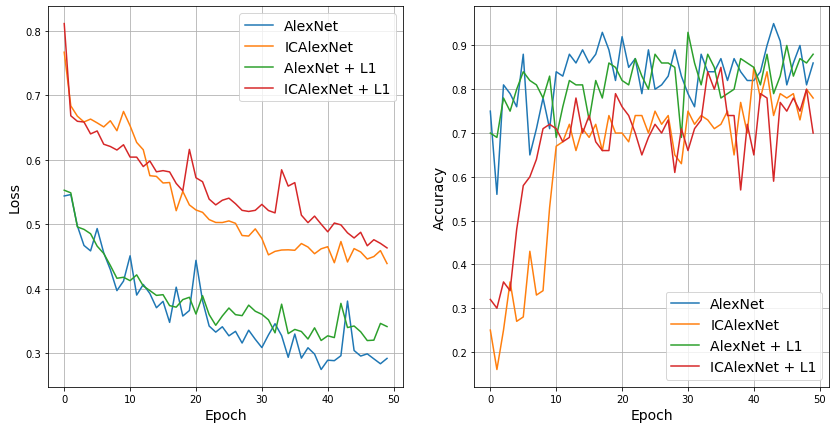

In [114]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axs[0].grid()
axs[0].plot(alexnet_val_losses, label="AlexNet")
axs[0].plot(posalex_loss, label="ICAlexNet")
axs[0].plot(alexl1_loss, label="AlexNet + L1")
axs[0].plot(posalexl1_loss, label="ICAlexNet + L1")
axs[0].set_xlabel("Epoch", fontsize=14)
axs[0].set_ylabel("Loss", fontsize=14)
axs[0].legend(fontsize=14)

axs[1].grid()
axs[1].plot(alexnet_val_accs, label="AlexNet")
axs[1].plot(posalex_acc, label="ICAlexNet")
axs[1].plot(alexl1_acc, label="AlexNet + L1")
axs[1].plot(posalexl1_acc, label="ICAlexNet + L1")
axs[1].legend(fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=14)
axs[1].set_ylabel("Accuracy", fontsize=14)
plt.show()